# Chi Squared Analysis

Chi-squared (χ²) is a statistical test used to determine the association between two categorical variables. It is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories of a contingency table.

The chi-squared test is often used in hypothesis testing to evaluate the null hypothesis that there is no association between the two variables. The test statistic is calculated as the sum of the squared differences between the observed and expected frequencies, divided by the expected frequencies.

The formula for the chi-squared statistic is:

χ² = ∑(O - E)² / E

where O is the observed frequency, E is the expected frequency, and the sum is taken over all categories.

The chi-squared test produces a p-value, which is the probability of observing a test statistic as extreme as the one calculated, assuming that the null hypothesis is true. A small p-value indicates that the observed frequencies are significantly different from the expected frequencies, and we reject the null hypothesis.

In Python, you can perform a chi-squared test using the scipy.stats module. The scipy.stats.chi2_contingency() function can be used to calculate the chi-squared statistic and the associated p-value for a contingency table.

## Table of Contents
* [Connect to Database ](#Connect-to-database)
* [Import Datasets](#Import-Dataset)
* [Remove Stopwords](#Remove-stopwords)
* [Lemmatization](#Lemmatization)

## Connect to Database

In [1]:
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *
from Data_with_NLP import *
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *
from Data_with_NLP import *

In [9]:
AlertP1=connection("/Users/MarouanKamoun/Desktop/HGO pbl/credentials.csv")

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',), ('hgo_data_032023',)]
657


## Import Datasets

In [11]:
#changing columns with date to a datetime
date_format_alertP1(AlertP1)
#change the blank values in proveniencia and priority to unknown
replace_blank(AlertP1)
#merge duplicated entity
entity_duplicated(AlertP1)
#changing the text to lower case
lowering_text(AlertP1)
#create a column with the output of a referral and select the refused and accepted ones
AlertP1=result(AlertP1)

In [12]:
# Import librariers 
!pip install wordcloud
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings(action="ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MarouanKamoun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MarouanKamoun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Remove Stopwords

In [13]:

# Get rid of special characters and transform Texto column to Latin words
AlertP1['Texto'] = AlertP1['Texto'].apply(lambda x: unidecode(x))

#The re.sub function is used to substitute all digits (\d) with an empty string
AlertP1['Texto'] = AlertP1['Texto'].apply(lambda x: re.sub(r'\d', '', x))

# Remove all names in Texto variable
# This function uses a regular expression to find all words in the text that start with a 
# capital letter (\b[A-Z][a-z]+\b), which are assumed to be names
text = AlertP1['Texto'] 

# remove all hyphens from the text
text = text.replace('-', '')

def remove_names(text):
    # Find all words that start with a capital letter
    names = re.findall(r'\b[A-Z][a-z]+\b', text)
    
    # Replace the names with an empty string
    for name in names:
        text = text.replace(name, '')
        
    return text

In [14]:
# Create an empty list to store the text
text_list = []

# Loop through the 'text' column
for text in text.str.lower(): # Transform every word to lower case
    text_list.append(text)

# Print the list of text
#print(text_list)

In [15]:
# Download the Portuguese stop words
nltk.download('stopwords')
nltk.download('punkt')

# Get the Portuguese stop words
stop_words = set(stopwords.words('portuguese'))

# Manually remove stopwords
stop_words.update(['-//','.', ',','(',')',':','-','?','+','/',';','2','1','drª','``','','3','desde','anos','doente','consulta','alterações','se',"''",'cerca','refere','hgo','utente','vossa','s','...','ainda','c','filha','costa','dr.','pereira','ja','--','p','dr','h','n','>','q','//','..','b','++','%','//','-','+++/','=','+++/'])

# Create a new list to store the filtered text
filtered_text = []

# Loop through the text_list and remove the stop words
for text in text_list:
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stop_words]
    filtered_text.append(" ".join(words))

# Print the filtered text
#print(filtered_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MarouanKamoun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MarouanKamoun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
# Save the filtered text as a new column to the dataframe
AlertP1['filtered_text'] = filtered_text

In [13]:
# import math

# # Split data into train and test
# AlertP1_sorted = AlertP1[AlertP1['Texto']!=''].sort_values(by='DATA_RECEPCAO')

# # calculate the index for the split
# split_index = math.ceil(0.8 * len(AlertP1_sorted))

# # split the data frame into test and train sets
# train_set = AlertP1_sorted.iloc[:split_index]
# test_set = AlertP1_sorted.iloc[split_index:]

## Lemmatization

Lemmatization is a text normalization technique used in Natural Language Processing (NLP), that switches any kind of a word to its base root mode. Lemmatization is responsible for grouping different inflected forms of words into the root form, having the same meaning

In [17]:
# Define function for lemmatization
def spacy_lemmatizer(df):
    import spacy
    import pt_core_news_md
    nlp = pt_core_news_md.load()

    doclist = list(nlp.pipe(df))

    docs=[]
    for i, doc in enumerate(doclist):
        docs.append(' '.join([listitem.lemma_ for listitem in doc]))
        
    return docs

In [18]:
AlertP1['text_lemmatized'] = spacy_lemmatizer(AlertP1['filtered_text'])

In [19]:
import math

# Split data into train and test
AlertP1_sorted = AlertP1[AlertP1['Texto']!=''].sort_values(by='DATA_RECEPCAO')

# calculate the index for the split
split_index = math.ceil(0.8 * len(AlertP1_sorted))

# split the data frame into test and train sets
train_set = AlertP1_sorted.iloc[:split_index]
test_set = AlertP1_sorted.iloc[split_index:]

In [20]:
# create an empty list to store the words
word_list = []

# loop through each row of the "text_column" column
for index, row in train_set.iterrows():
    
    # split the text into individual words using whitespace as a delimiter
    words = row['filtered_text'].split()
    # add the words to the word list
    word_list.extend(words)

# print the word list
#print(word_list)

In [21]:
# create an empty list to store the words
word_list = []

# loop through each row of the "text_column" column
for index, row in train_set.iterrows():
    
    # split the text into individual words using whitespace as a delimiter
    words = row['filtered_text'].split()
    
    # remove hyphens from the words and add them to the word list
    word_list.extend([word.replace('-', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('/', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('\-', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('\.', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('*', ' ') for word in words])
    # remove slash from the words and ass them to the list
    word_list.extend([word.replace('+', ' ') for word in words])
    

# print the cleaned word list
#print(word_list)

In [22]:
Lemma = spacy_lemmatizer(word_list) # Call lemmatizer function

# print length of word_list and compare the count after doing lemmatization
from collections import Counter

items = Counter(Lemma).keys()
print('The number of words after lemmatization:',len(items))

items2 = Counter(word_list).keys()
print('The number of words before lemmatization:',len(items2))

The number of words after lemmatization: 8237
The number of words before lemmatization: 10244


In [23]:
# apply the spacy_lemmatizer function to each row in the 'text' column
# train_set['text_lemmatized'] = spacy_lemmatizer(train_set['filtered_text'])

# drop rows with empty strings
train_set_filtered = train_set[['text_lemmatized','filtered_text']].replace('', pd.NA).dropna()
train_set_filtered = pd.DataFrame(train_set_filtered)
train_set_filtered

,text_lemmatized,filtered_text
630,idade tremor acentuar membro alto agravamento ...,idade tremor acentuado membros superiores agra...
752,pe pendente instalacao ha mês atrofiar muscula...,pe pendente instalacao ha meses atrofia muscul...
938,sintomatologia ap diabete tipo hta vir acompan...,sintomatologia ap diabetes tipo hta vem acompa...
1537,relatorio clinico,relatorio clinico
985,trazer inumero relatorio ida hgo-su vulvo-vagi...,traz inumeros relatorios idas hgo-su vulvo-vag...
...,...,...
15,homem provavel demencia vascular agravamento p...,homem provavel demencia vascular agravamento p...
1498,problema saude resolver demencia se enil / alz...,problema saude resolver demencia senil/alzheim...
244,antecedente epilepsia + ultimo ano crise frequ...,antecedentes epilepsia +ultimo ano crises freq...
1118,mulher idade diagnosticos dislipidemia hipertr...,mulher idade diagnosticos dislipidemia hipertr...


In [24]:
len(set(Lemma))

8237

## Chi Squared 

In [25]:
unique_words = list(set(Lemma))
# unique_words.remove('')
len(unique_words)

8237

In [26]:
unique_words_2 = []
for word in unique_words:
    word2 = re.escape(word)
    word_regex = '([\W\s]{1}' + word2 + '[\W\s]{1})'
    unique_words_2.append(word_regex)

In [27]:
original_columns = list(train_set.columns)

In [28]:
def word_dummy(df, column, list):
    # list = ["cefaleia","demência","convulsão", "epilepsia", "sincope", "vertigem", "tremor", "acidente vascular cerebral"]
    for d in list:
        column_name = d.replace('([\W\s]{1}', '')
        column_name = column_name.replace('[\W\s]{1})', '')
        df[column_name] = df[column].str.contains(d)
        df[column_name] = df[column_name].astype(int)
    return df

In [29]:
unique_words = [re.escape(word) for word in unique_words]
dataframe = train_set.copy()
word_dummy(dataframe,'text_lemmatized',unique_words_2)
dataframe.result

630     1
752     1
938     1
1537    0
985     1
       ..
15      0
1498    1
244     0
1118    1
1765    1
Name: result, Length: 1288, dtype: object

In [30]:
import pandas as pd
from scipy.stats import chi2_contingency

original_result = original_columns.remove('result')

dataset = dataframe.drop(original_columns,axis=1)# Features


dataset_columns = list(dataset.columns)
# dataset_columns = dataset_columns.remove('result')


chi_test = pd.DataFrame(columns=['word', 'chi2_stats', 'p_value'])

for i in dataset_columns:
    
    # Create the contingency table
    contingency_table = pd.crosstab(index=dataset['result'], columns=dataset[i])
    # Perform the chi-squared test and print the results
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    chi_test = chi_test.append({'word': i, 'chi2_stats': chi2, 'p_value': p}, ignore_index=True)

    # print(f"Chi-squared test statistic: {chi2}")
    # print(f"P-value: {p}")

print(chi_test)


                   word   chi2_stats        p_value
0                result  1283.327357  4.747215e-281
1                 punho     1.033131   3.094245e-01
2     incompatibilidade     0.169354   6.806868e-01
3                  Metf     0.000000   1.000000e+00
4            puntiforme     0.000000   1.000000e+00
...                 ...          ...            ...
8233          ossicular     0.000000   1.000000e+00
8234               cujo     0.583044   4.451216e-01
8235       regularidade     0.033482   8.548130e-01
8236                hsc     0.000000   1.000000e+00
8237            navosso     0.000000   1.000000e+00

[8238 rows x 3 columns]


In [31]:
chi_test.sort_values(by=['chi2_stats'], inplace=True, ascending=False)
chi_test

,word,chi2_stats,p_value
0,result,1283.327357,4.747215e-281
6326,nao,64.673386,8.840085e-16
190,ha,46.260142,1.035491e-11
5693,medicar,34.756771,3.735772e-09
5305,tac,33.866401,5.902935e-09
...,...,...,...
4735,valdacor,0.000000,1.000000e+00
1915,drt,0.000000,1.000000e+00
4732,meem,0.000000,1.000000e+00
4731,utimo,0.000000,1.000000e+00


In [32]:
chi2_columns = list(chi_test['word'].head(22))
chi2_columns.remove('result')
chi2_columns.remove('/')
chi2_features =  original_columns + chi2_columns 
chi2_features

['ID_DOENTE',
 'PROCESSO',
 'COD_REFERENCIA',
 'COD_PZ',
 'COD_UNID_SAUDE_PROV',
 'UNID_PROV',
 'TIPO_UNID',
 'PROVENIENCIA',
 'COD_CTH_PRIOR',
 'CTH_PRIOR',
 'COD_MOTIVO_RECUSA',
 'DES_MOTIVO_RECUSA',
 'COD_ESPECIALIDADE',
 'DES_ESPECIALIDADE',
 'agrupadora',
 'OUTRA_ENTIDADE',
 'DATA_RECEPCAO',
 'DATA_ENVIO',
 'DATA_RETORNO',
 'NUM_TAXA',
 'ESTADO',
 'DATA_MARCACAO',
 'DATA_REALIZACAO',
 'OBSERVACOES',
 'Mês_entrada',
 'Ano_entrada',
 'trata data recusa',
 'resume saída',
 'mês_saida',
 'ano_saida',
 'Texto',
 'clean_text',
 'filtered_text',
 'text_lemmatized',
 'nao',
 'ha',
 'medicar',
 'tac',
 'ce',
 'ter',
 'mês',
 'mg',
 'sintomatologia',
 'algum',
 'outro',
 'analise',
 'tremor',
 'ligeiro',
 'dificuldade',
 'avaliacao',
 'tac\\ ce',
 'alteracoe',
 'vez',
 'repouso']

In [33]:
chi2_columns

['nao',
 'ha',
 'medicar',
 'tac',
 'ce',
 'ter',
 'mês',
 'mg',
 'sintomatologia',
 'algum',
 'outro',
 'analise',
 'tremor',
 'ligeiro',
 'dificuldade',
 'avaliacao',
 'tac\\ ce',
 'alteracoe',
 'vez',
 'repouso']

In [34]:
chi2_columns_2 = []
for word in chi2_columns:
    word2 = re.escape(word)
    word_regex = '([\W\s]{1}' + word2 + '[\W\s]{1})'
    chi2_columns_2.append(word_regex)
chi2_columns_2

['([\\W\\s]{1}nao[\\W\\s]{1})',
 '([\\W\\s]{1}ha[\\W\\s]{1})',
 '([\\W\\s]{1}medicar[\\W\\s]{1})',
 '([\\W\\s]{1}tac[\\W\\s]{1})',
 '([\\W\\s]{1}ce[\\W\\s]{1})',
 '([\\W\\s]{1}ter[\\W\\s]{1})',
 '([\\W\\s]{1}mês[\\W\\s]{1})',
 '([\\W\\s]{1}mg[\\W\\s]{1})',
 '([\\W\\s]{1}sintomatologia[\\W\\s]{1})',
 '([\\W\\s]{1}algum[\\W\\s]{1})',
 '([\\W\\s]{1}outro[\\W\\s]{1})',
 '([\\W\\s]{1}analise[\\W\\s]{1})',
 '([\\W\\s]{1}tremor[\\W\\s]{1})',
 '([\\W\\s]{1}ligeiro[\\W\\s]{1})',
 '([\\W\\s]{1}dificuldade[\\W\\s]{1})',
 '([\\W\\s]{1}avaliacao[\\W\\s]{1})',
 '([\\W\\s]{1}tac\\\\\\ ce[\\W\\s]{1})',
 '([\\W\\s]{1}alteracoe[\\W\\s]{1})',
 '([\\W\\s]{1}vez[\\W\\s]{1})',
 '([\\W\\s]{1}repouso[\\W\\s]{1})']

In [35]:
def log_regression(features,target):
    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2,random_state=16,shuffle=False)
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression(random_state=16)
    # fit the model with data
    clf=logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    return y_pred,clf.coef_, clf.intercept_,X_train, X_test, y_train, y_test

In [36]:
chi_test['word_length'] = chi_test['word'].str.len()
chi_test

,word,chi2_stats,p_value,word_length
0,result,1283.327357,4.747215e-281,6
6326,nao,64.673386,8.840085e-16,3
190,ha,46.260142,1.035491e-11,2
5693,medicar,34.756771,3.735772e-09,7
5305,tac,33.866401,5.902935e-09,3
...,...,...,...,...
4735,valdacor,0.000000,1.000000e+00,8
1915,drt,0.000000,1.000000e+00,3
4732,meem,0.000000,1.000000e+00,4
4731,utimo,0.000000,1.000000e+00,5


In [37]:
data = AlertP1.copy()
data=bef_accepted(data)
class_area(data)
text_length(data)
referral_steps(data)
speciality(data)
data=unit(data)
word_dummy(data,'text_lemmatized',chi2_columns_2)
data


,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,PROVENIENCIA,COD_CTH_PRIOR,CTH_PRIOR,...,outro,analise,tremor,ligeiro,dificuldade,avaliacao,tac\\\ ce,alteracoe,vez,repouso
1499,01-12-1GBF,MIVNNVE,LPHRRVQP,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0
959,0F-12-1GAG,LLCCECB,LRHHVTQR,GAGBESD,3151571,USF FFMAIS-CS SEIXAL,CS/USF,CTH,,unknown,...,0,0,0,0,0,0,0,1,0,0
868,0F-12-1GAS,LLCJILJ,LQHOOLQV,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0
1519,0S-12-1GBF,MIVEMLC,LRHPVSVU,ZHEEZFSC,3151571,USF FFMAIS-CS SEIXAL,CS/USF,CTH,3,Normal,...,1,0,0,0,1,1,0,1,1,0
4844,"A,CBE+SA",VMNNVICN,LQHQLSHL,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,ZZZZB,BIJJVNJN,LRHRUSHO,ZHCBZAHZ,3150572,USF MONTE DA CAPARICA,CS/USF,CTH,,unknown,...,0,0,0,0,0,0,0,0,0,0
6526,ZZZZHA,BMJIDEDD,LQHSSUHH,GEASHED,3152471,USF SERVIR SAUDE-CS,CS/USF,CTH,3,Normal,...,0,0,0,0,0,0,0,0,0,0
6528,ZZZZSD,BMJIDCLL,LRHOUTQL,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0
6527,ZZZZSH,BMJIDCLJ,LQHLTUVQ,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0


## Add NLP Features

In [38]:
data1=data.copy()
#add symptoms column
symptoms_column(data1)
#add exams columns
exams(data1)
#add comorbidities columns
comorbidities(data1)
#add medication columns
medication_column(data1)

data1

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,PROVENIENCIA,COD_CTH_PRIOR,CTH_PRIOR,...,alteracoe,vez,repouso,symptom_1,symptom_0,exam_identified,comorbidity_identified,medication_level_1,medication_level_2,medication_level_3
1499,01-12-1GBF,MIVNNVE,LPHRRVQP,,0,,OUTRA,SAM,,unknown,...,0,0,0,1,0,0,0,0,0,0
959,0F-12-1GAG,LLCCECB,LRHHVTQR,GAGBESD,3151571,USF FFMAIS-CS SEIXAL,CS/USF,CTH,,unknown,...,1,0,0,4,2,0,0,0,2,0
868,0F-12-1GAS,LLCJILJ,LQHOOLQV,,0,,OUTRA,SAM,,unknown,...,0,0,0,1,0,0,1,0,0,0
1519,0S-12-1GBF,MIVEMLC,LRHPVSVU,ZHEEZFSC,3151571,USF FFMAIS-CS SEIXAL,CS/USF,CTH,3,Normal,...,1,1,0,3,6,0,0,1,9,6
4844,"A,CBE+SA",VMNNVICN,LQHQLSHL,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,ZZZZB,BIJJVNJN,LRHRUSHO,ZHCBZAHZ,3150572,USF MONTE DA CAPARICA,CS/USF,CTH,,unknown,...,0,0,0,0,0,0,0,0,0,0
6526,ZZZZHA,BMJIDEDD,LQHSSUHH,GEASHED,3152471,USF SERVIR SAUDE-CS,CS/USF,CTH,3,Normal,...,0,0,0,0,0,0,0,0,0,0
6528,ZZZZSD,BMJIDCLL,LRHOUTQL,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0
6527,ZZZZSH,BMJIDCLJ,LQHLTUVQ,,0,,OUTRA,SAM,,unknown,...,0,0,0,0,0,0,0,0,0,0


In [44]:
data1 = data1.sort_values('DATA_RECEPCAO')
data_ready = structured_data_dummies(data1)
data_ready=data_ready[data_ready['text_length']>0]
# data_ready = data_ready.drop(columns=[col for col in data_ready.columns if col not in chi2_features])
print(data_ready.columns)
data_ready

Index([             'ID_DOENTE',               'PROCESSO',
               'COD_REFERENCIA',                 'COD_PZ',
          'COD_UNID_SAUDE_PROV',              'UNID_PROV',
                    'TIPO_UNID',          'COD_CTH_PRIOR',
                    'CTH_PRIOR',      'COD_MOTIVO_RECUSA',
            'DES_MOTIVO_RECUSA',      'COD_ESPECIALIDADE',
            'DES_ESPECIALIDADE',             'agrupadora',
               'OUTRA_ENTIDADE',          'DATA_RECEPCAO',
                   'DATA_ENVIO',           'DATA_RETORNO',
                     'NUM_TAXA',                 'ESTADO',
                'DATA_MARCACAO',        'DATA_REALIZACAO',
                  'OBSERVACOES',            'Mês_entrada',
                  'Ano_entrada',      'trata data recusa',
                 'resume saída',              'mês_saida',
                    'ano_saida',                  'Texto',
                   'clean_text',                 'result',
                'filtered_text',        'text_lemmatized

,ID_DOENTE,PROCESSO,COD_REFERENCIA,COD_PZ,COD_UNID_SAUDE_PROV,UNID_PROV,TIPO_UNID,COD_CTH_PRIOR,CTH_PRIOR,COD_MOTIVO_RECUSA,...,unknown,Other specialities,2,3+,HGO,HOSP,UCSP,USF,outro,not accepted before
630,EGBZZB,VLNMEEM,LOHHHSHT,SSDBHEA,3150502,CHARNECA DA CAPARICA,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,0,0,1
1537,FGSEDD,MIVCNDB,LOHHLSTU,,0,,OUTRA,,unknown,7,...,1,0,0,0,1,0,0,0,0,1
1103,ESSSBD,LLDDNEN,LOHHLTSH,SCCBZCA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,0,...,0,1,0,0,0,0,0,1,0,1
752,DECZCS,VLEVCVE,LOHHLTOU,SCCDEGG,3151672,USF AMORA SAUDAVEL,CS/USF,,unknown,0,...,0,0,0,0,0,0,0,1,0,1
985,BSEZF,LLCBVJI,LOHHLTRS,SCCABHA,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,,unknown,53,...,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,FFDSBH,MILLLCJ,LSHUVULH,ZESCCSSF,3152401,UCSP CORROIOS,CS/USF,2,Prioritário,0,...,0,0,0,0,0,0,1,0,0,1
1335,EBBCSA,"I,IJME+LI",LSHVHLLH,ZESBAHAD,3150571,USF SOBREDA-CS COSTA CAPARICA,CS/USF,3,Normal,0,...,0,0,0,0,0,0,0,1,0,1
1177,ZHZFA,ILBIBCL,LSHVHLHP,ZESBFBCB,3152400,CORROIOS (SEDE),CS/USF,3,Normal,0,...,0,0,0,1,0,0,1,0,0,0
1332,FDSADA,IIJMMNJ,LSHVHSUR,ZESGGDFH,3150572,USF MONTE DA CAPARICA,CS/USF,,unknown,7,...,0,0,0,0,0,0,0,0,0,1


In [45]:
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text']
all_columns = list(data.columns)

for i in eliminate_cols:
    all_columns.remove(i)

print(all_columns)

X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable

X


['PROVENIENCIA', 'filtered_text', 'text_lemmatized', 'before_accepted', 'area', 'text_length', 'step', 'speciality_type', 'unit', 'nao', 'ha', 'medicar', 'tac', 'ce', 'ter', 'mês', 'mg', 'sintomatologia', 'algum', 'outro', 'analise', 'tremor', 'ligeiro', 'dificuldade', 'avaliacao', 'tac\\\\\\ ce', 'alteracoe', 'vez', 'repouso']


,PROVENIENCIA,filtered_text,text_lemmatized,before_accepted,area,text_length,step,speciality_type,unit,nao,...,outro,analise,tremor,ligeiro,dificuldade,avaliacao,tac\\\ ce,alteracoe,vez,repouso
1499,SAM,status pos ait estenose carotida interna direita,status pos ait estenose carotido interno direita,not accepted before,outside area,51,1,General Neurology,HGO,0,...,0,0,0,0,0,0,0,0,0,0
959,CTH,problema saude resolver parkinsonismo/paralisi...,problema saude resolver parkinsonismo / parali...,not accepted before,inside area,691,1,General Neurology,USF,1,...,0,0,0,0,0,0,0,1,0,0
868,SAM,ataxia marcha desiquilibrio sind meniere insuf...,ataxio marcha desiquilibrio Sind meniere insuf...,not accepted before,outside area,66,1,General Neurology,HGO,0,...,0,0,0,0,0,0,0,0,0,0
1519,CTH,envio idade quadro evolucao perda progressiva ...,envio idade quadro evolucao perda progressivo ...,not accepted before,inside area,2925,1,General Neurology,USF,1,...,1,0,0,0,1,1,0,1,1,0
4844,SAM,,,not accepted before,outside area,0,1,General Neurology,HGO,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,CTH,,,not accepted before,inside area,0,1,General Neurology,CS,0,...,0,0,0,0,0,0,0,0,0,0
6526,CTH,,,not accepted before,inside area,0,1,General Neurology,USF,0,...,0,0,0,0,0,0,0,0,0,0
6528,SAM,,,not accepted before,outside area,0,1,General Neurology,HGO,0,...,0,0,0,0,0,0,0,0,0,0
6527,SAM,,,not accepted before,outside area,0,1,General Neurology,HGO,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
#split dataset in features and target variable// Question: is it the right option?


# assuming your data is stored in a DataFrame object called 'data'
data_ready.columns = data_ready.columns.astype(str)

eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text','filtered_text','text_lemmatized']
X = data_ready.drop(eliminate_cols,axis=1)# Features
y = data_ready.result # Target variable

y
features=X.columns
#log_regression is defined in functions
y_pred,coefficients,intercept,X_train, X_test, y_train, y_test=log_regression(X,y)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=coefficients.T
df


,Feature,coefficients
0,text_length,0.000244
1,nao,0.434537
2,ha,0.346062
3,medicar,0.080337
4,tac,0.272085
5,ce,0.204059
6,ter,0.400079
7,mês,0.426662
8,mg,0.253870
9,sintomatologia,0.258859


In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#split dataset in features and target variable// Question: is it the right option?
data_ready.columns = data_ready.columns.astype(str)
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto','clean_text','filtered_text','text_lemmatized']
X = data_ready.drop(eliminate_cols,axis=1)# Features
y = data_ready.result # Target variable
features=X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)
# instantiate the model (using the default parameters)
logreg =RandomForestClassifier(n_estimators=500, random_state=42)
# fit the model with data
clf=logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=clf.feature_importances_.T
df.sort_values(by='coefficients',ascending=False)

,Feature,coefficients
0,text_length,0.305400
21,symptom_1,0.089427
32,Other specialities,0.056098
22,symptom_0,0.045529
31,unknown,0.039484
26,medication_level_2,0.032803
38,USF,0.028883
25,medication_level_1,0.027085
35,HGO,0.024268
40,not accepted before,0.023971


In [76]:
y_df = pd.DataFrame(y_test)
distribution = y_df.value_counts()
distribution

result
1         211
0         111
dtype: int64

Accuracy: 0.72
Recall: 0.90
Precision: 0.74
              precision    recall  f1-score   support

     refused       0.67      0.39      0.49       111
    accepted       0.74      0.90      0.81       211

    accuracy                           0.72       322
   macro avg       0.70      0.64      0.65       322
weighted avg       0.71      0.72      0.70       322



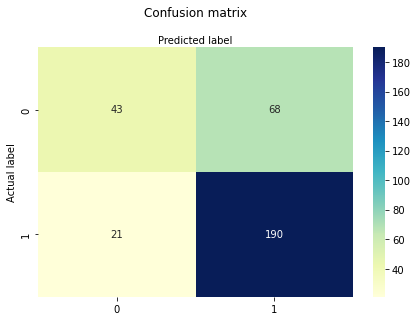

In [49]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}".format(accuracy))
# Evaluate the recall of the model
recall = recall_score(y_test, y_pred)
print("Recall: {:.2f}".format(recall))

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred)
print("Precision: {:.2f}".format(precision))

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))

In [78]:
p_values = p_value(X,y)
p_values.sort_values(by=['p_value'], inplace=True, ascending=False)
p_values

,Feature,p_value
35,USF A,7.602602e-01
34,UCSP,5.678582e-01
32,3+,1.193271e-01
37,outro,9.732322e-02
31,2,3.219752e-02
28,SON,7.611581e-04
33,HOSP,3.315177e-04
27,SAM,1.051842e-04
38,not accepted before,4.943833e-05
20,repouso,3.364106e-06


In [79]:
#
results = chi_test.merge(p_values.set_index('Feature'), left_on='word', right_index=True, suffixes=('_chi_test', '_log_reg')).merge(df.set_index('Feature'), left_on='word', right_index=True, suffixes=('_chi_test', '_log_reg'))

results

,word,chi2_stats,p_value_chi_test,word_length,p_value_log_reg,coefficients
4987,nao,64.673386,8.840085e-16,3,9.668090e-18,0.452141
5529,ha,46.260142,1.035491e-11,2,3.700309e-13,0.397137
2784,medicar,34.756771,3.735772e-09,7,8.333934e-12,0.150979
1720,tac,33.866401,5.902935e-09,3,1.913518e-08,0.496369
5862,ce,29.460287,5.707430e-08,2,1.585181e-09,0.248331
3924,ter,28.960680,7.386245e-08,3,5.127481e-10,0.292935
5684,mês,25.973793,3.460836e-07,3,4.228173e-09,0.354117
1096,mg,25.446452,4.548333e-07,2,8.855440e-11,0.201449
4298,algum,22.979017,1.637793e-06,5,6.801057e-08,0.274791
2731,sintomatologia,22.979017,1.637793e-06,14,1.162691e-06,0.152187


In [80]:
word_count = pd.DataFrame(columns=['word', 'count'])

for i, word in enumerate(results.word):
    count = dataset[word].sum()
    word_count = word_count.append({'word': word, 'count': count}, ignore_index=True)


word_count 

,word,count
0,nao,340
1,ha,305
2,medicar,249
3,tac,235
4,ce,225
5,ter,166
6,mês,142
7,mg,123
8,algum,113
9,sintomatologia,113


In [81]:
results = results.merge(word_count.set_index('word'), left_on='word', right_index=True, suffixes=('_chi_test', '_count'))
results

,word,chi2_stats,p_value_chi_test,word_length,p_value_log_reg,coefficients,count
4987,nao,64.673386,8.840085e-16,3,9.668090e-18,0.452141,340
5529,ha,46.260142,1.035491e-11,2,3.700309e-13,0.397137,305
2784,medicar,34.756771,3.735772e-09,7,8.333934e-12,0.150979,249
1720,tac,33.866401,5.902935e-09,3,1.913518e-08,0.496369,235
5862,ce,29.460287,5.707430e-08,2,1.585181e-09,0.248331,225
3924,ter,28.960680,7.386245e-08,3,5.127481e-10,0.292935,166
5684,mês,25.973793,3.460836e-07,3,4.228173e-09,0.354117,142
1096,mg,25.446452,4.548333e-07,2,8.855440e-11,0.201449,123
4298,algum,22.979017,1.637793e-06,5,6.801057e-08,0.274791,113
2731,sintomatologia,22.979017,1.637793e-06,14,1.162691e-06,0.152187,113


In [82]:
results.to_clipboard()

# 